In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input ,SpatialDropout3D,Dropout
import keras
from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from sklearn.model_selection import KFold

In [2]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
y_All=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2018-12-31'))
y_All=y_All/25.0

In [3]:
#Surface data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')
# 850 Data
tuv850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')
z850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_z_daily_NovDecJan.nc')
#700 Data
w700Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_700_w_daily_NovDecJan.nc')
# Read Orography
OroData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')
z500Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_500_z_daily_NovDecJan.nc')

In [4]:
rh = (e**((17.625*(d2mData.d2m.values-273.15))/(243.04+(d2mData.d2m.values-273.15)))/e**((17.625*(t2mData.t2m.values-273.15))/(243.04+(t2mData.t2m.values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [5]:
# Calculate wind speed 
ws = ((v10Data.v10.values**2)+(u10Data.u10.values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [6]:
#Calculate inv
inv=t2mData.t2m.values-tuv850Data.t.values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'

In [7]:
#u shear calculation
ushear=(tuv850Data.u.values-u10Data.u10.values)/(z850Data.z.values/9.81) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'

In [8]:
# AO Input
AOData1 = xr.open_dataset('../../../Data/AO_EU/AO_Calculated.nc')
print(AOData1)

Darray=np.zeros((t2mData.time.shape[0],t2mData.latitude.shape[0], t2mData.longitude.shape[0]))
for t in range(AOData1.time.shape[0]) :
    Darray[t,:,:]=np.full((t2mData.latitude.shape[0], t2mData.longitude.shape[0]), AOData1.AO[t].values)
AOData=xr.Dataset({'AO': (('time','latitude','longitude'), Darray)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})    

<xarray.Dataset>
Dimensions:  (time: 3772)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
Data variables:
    AO       (time) float32 ...


In [9]:
#EU Input
EUData1 = xr.open_dataset('../../../Data/AO_EU/EU_NovDecJan.nc')
Darray=np.zeros((t2mData.time.shape[0],t2mData.latitude.shape[0], t2mData.longitude.shape[0]))
for t in range(EUData1.time.shape[0]) :
    Darray[t,:,:]=np.full((t2mData.latitude.shape[0], t2mData.longitude.shape[0]), EUData1.EUVal[t].values)
EUData=xr.Dataset({'EU': (('time','latitude','longitude'), Darray)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})    

In [10]:
t2m=t2mData.t2m.shift(time=1)
ws=ws_ds.ws.shift(time=1)
rh=rh_ds.rh.shift(time=1)
inv=inv_ds.inv.shift(time=1)
w=w700Data.w.shift(time=1)
ushear=ushear_ds.ushear.shift(time=1)
ao=AOData.AO.shift(time=1)
eu=EUData.EU.shift(time=1)

In [11]:
t2mTsAll=t2m[((t2m.time.dt.month>11) | (t2m.time.dt.month<2)) & (t2m.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wsTsAll=ws[((ws.time.dt.month>11) | (ws.time.dt.month<2)) & (ws.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
rhTsAll=rh[((rh.time.dt.month>11) | (rh.time.dt.month<2)) & (rh.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
invTsAll=inv[((inv.time.dt.month>11) | (inv.time.dt.month<2)) & (inv.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
ushearTsAll=ushear[((ushear.time.dt.month>11) | (ushear.time.dt.month<2)) & (ushear.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
aoTsAll=ao[((ao.time.dt.month>11) | (ao.time.dt.month<2)) & (ao.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
euTsAll=eu[((eu.time.dt.month>11) | (eu.time.dt.month<2)) & (eu.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wTsAll=w[((w.time.dt.month>11) | (w.time.dt.month<2)) & (w.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))

In [12]:
# create mask
oro = OroData.z.sel(latitude=slice(35,0),longitude=slice(50,100))
oro.values = OroData.z.sel(latitude=slice(35,0),longitude=slice(50,100)).values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values

In [13]:
t2mTsAll.values=t2mTsAll.values*mask
wsTsAll.values=wsTsAll.values*mask
rhTsAll.values=rhTsAll.values*mask
invTsAll.values=invTsAll.values*mask
ushearTsAll.values=ushearTsAll.values*mask
wTsAll.values=wTsAll.values*mask
aoTsAll.values=aoTsAll.values*mask
euTsAll.values=euTsAll.values*mask

In [14]:
t2mTsAll.values=xr.where(np.isnan(t2mTsAll.values),  0.000000000001,t2mTsAll.values)
wsTsAll.values=xr.where(np.isnan(wsTsAll.values),  0.000000000001,wsTsAll.values)
rhTsAll.values=xr.where(np.isnan(rhTsAll.values),  0.000000000001,rhTsAll.values)
invTsAll.values=xr.where(np.isnan(invTsAll.values),  0.000000000001,invTsAll.values)
ushearTsAll.values=xr.where(np.isnan(ushearTsAll.values),  0.000000000001,ushearTsAll.values)
wTsAll.values=xr.where(np.isnan(wTsAll.values),  0.000000000001,wTsAll.values)
aoTsAll.values=xr.where(np.isnan(aoTsAll.values),  0.000000000001,aoTsAll.values)
euTsAll.values=xr.where(np.isnan(euTsAll.values),  0.000000000001,euTsAll.values)

In [15]:
t1=t2mTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
t2mTsAll.values=t1.unstack()

t1=wsTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wsTsAll.values=t1.unstack()

t1=rhTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
rhTsAll.values=t1.unstack()

t1=invTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
invTsAll.values=t1.unstack()

t1=ushearTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
ushearTsAll.values=t1.unstack()

t1=aoTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
aoTsAll.values=t1.unstack()

t1=euTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
euTsAll.values=t1.unstack()

t1=wTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wTsAll.values=t1.unstack()


In [16]:
t2mAll=t2mTsAll.values
t2mAll=t2mAll[:,:,:,None]
t2mAll.shape


wsAll=wsTsAll.values
wsAll=wsAll[:,:,:,None]
wsAll.shape

rhAll=rhTsAll.values
rhAll=rhAll[:,:,:,None]
rhAll.shape


invAll=invTsAll.values
invAll=invAll[:,:,:,None]
invAll.shape

wAll=wTsAll.values
wAll=wAll[:,:,:,None]
wAll.shape

ushearAll=ushearTsAll.values
ushearAll=ushearAll[:,:,:,None]
ushearAll.shape

aoAll=aoTsAll.values
aoAll=aoAll[:,:,:,None]
aoAll.shape

euAll=euTsAll.values
euAll=euAll[:,:,:,None]
euAll.shape

(2418, 18, 26, 1)

In [17]:
y=y_All.values
y=y[:,None]
y.shape

(2418, 1)

In [18]:
#X=np.array([rhAll,wsAll,invAll,wAll,ushearAll,aoAll,euAll])
X=np.array([t2mAll,rhAll,wsAll,invAll,wAll,ushearAll,aoAll,euAll])

X = np.einsum('lkija->klija',X)
X.shape


(2418, 8, 18, 26, 1)

### KFold CV

#  LeNet-5  Architecture

Epoch 1/20
61/61 [==============================] - 8s 129ms/step - loss: 0.2481 - mse: 0.1141 - val_loss: 0.1462 - val_mse: 0.0334
Epoch 2/20
61/61 [==============================] - 8s 127ms/step - loss: 0.1338 - mse: 0.0291 - val_loss: 0.1214 - val_mse: 0.0228
Epoch 3/20
61/61 [==============================] - 8s 127ms/step - loss: 0.1078 - mse: 0.0188 - val_loss: 0.1166 - val_mse: 0.0217
Epoch 4/20
61/61 [==============================] - 8s 126ms/step - loss: 0.1020 - mse: 0.0178 - val_loss: 0.1079 - val_mse: 0.0186
Epoch 5/20
61/61 [==============================] - 8s 128ms/step - loss: 0.0944 - mse: 0.0152 - val_loss: 0.1023 - val_mse: 0.0172
Epoch 6/20
61/61 [==============================] - 8s 127ms/step - loss: 0.0872 - mse: 0.0132 - val_loss: 0.1017 - val_mse: 0.0167
Epoch 7/20
61/61 [==============================] - 8s 124ms/step - loss: 0.0830 - mse: 0.0125 - val_loss: 0.0970 - val_mse: 0.0160
Epoch 8/20
61/61 [==============================] - 8s 126ms/step - loss: 0.

61/61 [==============================] - 8s 124ms/step - loss: 0.1666 - mse: 0.0426 - val_loss: 0.1628 - val_mse: 0.0453
Epoch 3/20
61/61 [==============================] - 8s 125ms/step - loss: 0.1351 - mse: 0.0307 - val_loss: 0.1315 - val_mse: 0.0269
Epoch 4/20
61/61 [==============================] - 8s 126ms/step - loss: 0.1168 - mse: 0.0228 - val_loss: 0.1191 - val_mse: 0.0216
Epoch 5/20
61/61 [==============================] - 8s 125ms/step - loss: 0.1082 - mse: 0.0197 - val_loss: 0.1284 - val_mse: 0.0274
Epoch 6/20
61/61 [==============================] - 8s 126ms/step - loss: 0.0946 - mse: 0.0151 - val_loss: 0.1115 - val_mse: 0.0202
Epoch 7/20
61/61 [==============================] - 8s 126ms/step - loss: 0.0919 - mse: 0.0143 - val_loss: 0.1168 - val_mse: 0.0221
Epoch 8/20
61/61 [==============================] - 8s 124ms/step - loss: 0.0883 - mse: 0.0132 - val_loss: 0.1138 - val_mse: 0.0217
Epoch 9/20
61/61 [==============================] - 8s 124ms/step - loss: 0.0808 - mse:

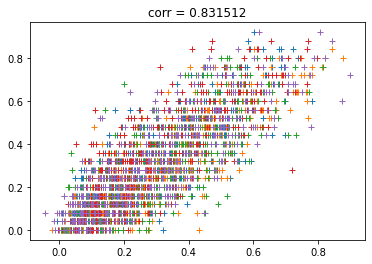

In [28]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn1 = Sequential()
    cnn1.add(Conv3D(8, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn1.add(MaxPooling3D(pool_size=2,padding='same'))
    cnn1.add(Conv3D(16, kernel_size=5, activation='relu',padding='same'))
    cnn1.add(MaxPooling3D(pool_size=2,padding='same'))

    cnn1.add(Flatten())

    cnn1.add(Dense(120, activation='relu'))
    cnn1.add(Dense(84, activation='relu'))
    cnn1.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn1.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn1.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn1.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn1.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn1.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("CNN1 LeNet-5")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    



Epoch 1/20
61/61 [==============================] - 2s 23ms/step - loss: 0.1968 - mse: 0.0629 - val_loss: 0.1941 - val_mse: 0.0672
Epoch 2/20
61/61 [==============================] - 1s 21ms/step - loss: 0.1598 - mse: 0.0422 - val_loss: 0.1331 - val_mse: 0.0303
Epoch 3/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1238 - mse: 0.0255 - val_loss: 0.1250 - val_mse: 0.0236
Epoch 4/20
61/61 [==============================] - 1s 21ms/step - loss: 0.1135 - mse: 0.0216 - val_loss: 0.1082 - val_mse: 0.0197
Epoch 5/20
61/61 [==============================] - 1s 21ms/step - loss: 0.0959 - mse: 0.0162 - val_loss: 0.1056 - val_mse: 0.0189
Epoch 6/20
61/61 [==============================] - 1s 21ms/step - loss: 0.0935 - mse: 0.0149 - val_loss: 0.1019 - val_mse: 0.0167
Epoch 7/20
61/61 [==============================] - 1s 21ms/step - loss: 0.0868 - mse: 0.0134 - val_loss: 0.1007 - val_mse: 0.0165
Epoch 8/20
61/61 [==============================] - 5s 90ms/step - loss: 0.0837 - m

61/61 [==============================] - 1s 21ms/step - loss: 0.1353 - mse: 0.0306 - val_loss: 0.1345 - val_mse: 0.0300
Epoch 4/20
61/61 [==============================] - 1s 21ms/step - loss: 0.1239 - mse: 0.0251 - val_loss: 0.1199 - val_mse: 0.0235
Epoch 5/20
61/61 [==============================] - 1s 20ms/step - loss: 0.1048 - mse: 0.0187 - val_loss: 0.1346 - val_mse: 0.0311
Epoch 6/20
61/61 [==============================] - 1s 21ms/step - loss: 0.1005 - mse: 0.0174 - val_loss: 0.1166 - val_mse: 0.0232
Epoch 7/20
61/61 [==============================] - 1s 21ms/step - loss: 0.0949 - mse: 0.0170 - val_loss: 0.1039 - val_mse: 0.0178
Epoch 8/20
61/61 [==============================] - 1s 22ms/step - loss: 0.0963 - mse: 0.0164 - val_loss: 0.1002 - val_mse: 0.0167
Epoch 9/20
61/61 [==============================] - 1s 21ms/step - loss: 0.0818 - mse: 0.0121 - val_loss: 0.1039 - val_mse: 0.0173
Epoch 10/20
61/61 [==============================] - 1s 21ms/step - loss: 0.0810 - mse: 0.0114

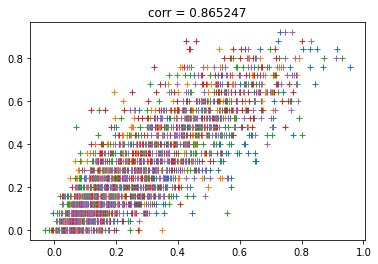

In [29]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn2 = Sequential()
    cnn2.add(Conv3D(8, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn2.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn2.add(Conv3D(16, kernel_size=5, activation='relu',padding='same'))
    cnn2.add(AveragePooling3D(pool_size=2,padding='same'))

    cnn2.add(Flatten())

    cnn2.add(Dense(120, activation='relu'))
    cnn2.add(Dense(84, activation='relu'))
    cnn2.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn2.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn2.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn2.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn2.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn2.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn2 LeNet-5 AvgPooling")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    

# Conv-Pool-Conv-Pool kind of architecture with doubling the number of filters every stage

Epoch 1/20
61/61 [==============================] - 31s 476ms/step - loss: 0.3426 - mse: 0.3957 - val_loss: 0.1673 - val_mse: 0.0425
Epoch 2/20
61/61 [==============================] - 29s 473ms/step - loss: 0.1693 - mse: 0.0445 - val_loss: 0.1314 - val_mse: 0.0273
Epoch 3/20
61/61 [==============================] - 29s 473ms/step - loss: 0.1225 - mse: 0.0257 - val_loss: 0.1149 - val_mse: 0.0209
Epoch 4/20
61/61 [==============================] - 29s 478ms/step - loss: 0.0995 - mse: 0.0170 - val_loss: 0.1108 - val_mse: 0.0213
Epoch 5/20
61/61 [==============================] - 29s 478ms/step - loss: 0.0954 - mse: 0.0157 - val_loss: 0.1011 - val_mse: 0.0166
Epoch 6/20
61/61 [==============================] - 29s 473ms/step - loss: 0.0927 - mse: 0.0148 - val_loss: 0.0968 - val_mse: 0.0153
Epoch 7/20
61/61 [==============================] - 33s 545ms/step - loss: 0.0804 - mse: 0.0114 - val_loss: 0.0997 - val_mse: 0.0157
Epoch 8/20
61/61 [==============================] - 29s 471ms/step - 

61/61 [==============================] - 32s 531ms/step - loss: 0.1364 - mse: 0.0295 - val_loss: 0.1161 - val_mse: 0.0219
Epoch 3/20
61/61 [==============================] - 30s 490ms/step - loss: 0.1055 - mse: 0.0185 - val_loss: 0.1171 - val_mse: 0.0204
Epoch 4/20
61/61 [==============================] - 30s 486ms/step - loss: 0.0965 - mse: 0.0155 - val_loss: 0.1001 - val_mse: 0.0166
Epoch 5/20
61/61 [==============================] - 29s 479ms/step - loss: 0.0833 - mse: 0.0119 - val_loss: 0.1020 - val_mse: 0.0175
Epoch 6/20
61/61 [==============================] - 30s 488ms/step - loss: 0.0841 - mse: 0.0121 - val_loss: 0.1000 - val_mse: 0.0158
Epoch 7/20
61/61 [==============================] - 30s 484ms/step - loss: 0.0775 - mse: 0.0104 - val_loss: 0.0912 - val_mse: 0.0138
Epoch 8/20
61/61 [==============================] - 30s 488ms/step - loss: 0.0745 - mse: 0.0100 - val_loss: 0.0947 - val_mse: 0.0154
Epoch 9/20
61/61 [==============================] - 30s 487ms/step - loss: 0.061

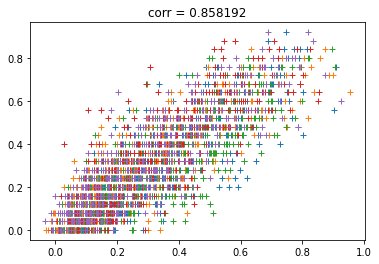

In [30]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn3 = Sequential()
    cnn3.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn3.add(MaxPooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(MaxPooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(MaxPooling3D(pool_size=2,padding='same'))

    cnn3.add(Flatten())

    cnn3.add(Dense(64, activation='relu'))
    cnn3.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn3.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn3.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn3.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn3.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn3.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn3 Conv-Pool-Conv-Pool MaxPooling")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/20
61/61 [==============================] - 3s 41ms/step - loss: 0.2059 - mse: 0.0677 - val_loss: 0.1672 - val_mse: 0.0453
Epoch 2/20
61/61 [==============================] - 2s 40ms/step - loss: 0.1737 - mse: 0.0469 - val_loss: 0.1529 - val_mse: 0.0384
Epoch 3/20
61/61 [==============================] - 2s 39ms/step - loss: 0.1431 - mse: 0.0337 - val_loss: 0.1491 - val_mse: 0.0322
Epoch 4/20
61/61 [==============================] - 2s 40ms/step - loss: 0.1172 - mse: 0.0221 - val_loss: 0.1156 - val_mse: 0.0222
Epoch 5/20
61/61 [==============================] - 2s 39ms/step - loss: 0.1129 - mse: 0.0215 - val_loss: 0.1089 - val_mse: 0.0190
Epoch 6/20
61/61 [==============================] - 2s 41ms/step - loss: 0.0954 - mse: 0.0157 - val_loss: 0.1049 - val_mse: 0.0175
Epoch 7/20
61/61 [==============================] - 2s 41ms/step - loss: 0.0950 - mse: 0.0155 - val_loss: 0.0983 - val_mse: 0.0154
Epoch 8/20
61/61 [==============================] - 2s 40ms/step - loss: 0.0896 - m

61/61 [==============================] - 2s 40ms/step - loss: 0.1488 - mse: 0.0356 - val_loss: 0.1381 - val_mse: 0.0316
Epoch 4/20
61/61 [==============================] - 2s 38ms/step - loss: 0.1276 - mse: 0.0276 - val_loss: 0.1157 - val_mse: 0.0210
Epoch 5/20
61/61 [==============================] - 2s 39ms/step - loss: 0.1071 - mse: 0.0203 - val_loss: 0.1104 - val_mse: 0.0194
Epoch 6/20
61/61 [==============================] - 6s 97ms/step - loss: 0.1022 - mse: 0.0179 - val_loss: 0.1068 - val_mse: 0.0184
Epoch 7/20
61/61 [==============================] - 2s 41ms/step - loss: 0.0968 - mse: 0.0166 - val_loss: 0.0990 - val_mse: 0.0163
Epoch 8/20
61/61 [==============================] - 2s 39ms/step - loss: 0.0884 - mse: 0.0137 - val_loss: 0.1202 - val_mse: 0.0250
Epoch 9/20
61/61 [==============================] - 2s 41ms/step - loss: 0.0925 - mse: 0.0148 - val_loss: 0.0925 - val_mse: 0.0142
Epoch 10/20
61/61 [==============================] - 2s 40ms/step - loss: 0.0833 - mse: 0.0119

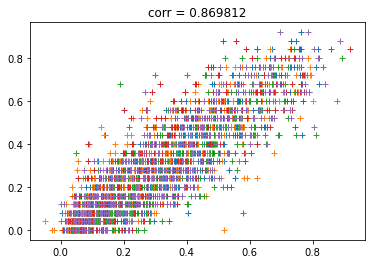

In [31]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn4 = Sequential()
    cnn4.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn4.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn4.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn4.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn4.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
    cnn4.add(AveragePooling3D(pool_size=2,padding='same'))

    cnn4.add(Flatten())

    cnn4.add(Dense(64, activation='relu'))
    cnn4.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn4.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn4.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn4.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn4.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn4.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn4 Conv-Pool-Conv-Pool AvgPooling")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    


# a vgg like model with the trend Conv-Conv-Pool-Conv-Conv-Pool

Epoch 1/20
61/61 [==============================] - 18s 281ms/step - loss: 0.4370 - mse: 0.7727 - val_loss: 0.1673 - val_mse: 0.0458
Epoch 2/20
61/61 [==============================] - 17s 277ms/step - loss: 0.1691 - mse: 0.0459 - val_loss: 0.1311 - val_mse: 0.0290
Epoch 3/20
61/61 [==============================] - 17s 276ms/step - loss: 0.1187 - mse: 0.0231 - val_loss: 0.1068 - val_mse: 0.0186
Epoch 4/20
61/61 [==============================] - 21s 349ms/step - loss: 0.1027 - mse: 0.0176 - val_loss: 0.1010 - val_mse: 0.0165
Epoch 5/20
61/61 [==============================] - 17s 278ms/step - loss: 0.0850 - mse: 0.0124 - val_loss: 0.0957 - val_mse: 0.0140
Epoch 6/20
61/61 [==============================] - 17s 276ms/step - loss: 0.0817 - mse: 0.0114 - val_loss: 0.0951 - val_mse: 0.0148
Epoch 7/20
61/61 [==============================] - 17s 274ms/step - loss: 0.0778 - mse: 0.0105 - val_loss: 0.0978 - val_mse: 0.0155
Epoch 8/20
61/61 [==============================] - 19s 319ms/step - 

61/61 [==============================] - 19s 319ms/step - loss: 0.1670 - mse: 0.0458 - val_loss: 0.1618 - val_mse: 0.0378
Epoch 3/20
61/61 [==============================] - 17s 283ms/step - loss: 0.1375 - mse: 0.0300 - val_loss: 0.1103 - val_mse: 0.0209
Epoch 4/20
61/61 [==============================] - 17s 279ms/step - loss: 0.1002 - mse: 0.0173 - val_loss: 0.1033 - val_mse: 0.0167
Epoch 5/20
61/61 [==============================] - 17s 277ms/step - loss: 0.0886 - mse: 0.0138 - val_loss: 0.1101 - val_mse: 0.0188
Epoch 6/20
61/61 [==============================] - 19s 314ms/step - loss: 0.0910 - mse: 0.0143 - val_loss: 0.0943 - val_mse: 0.0152
Epoch 7/20
61/61 [==============================] - 18s 289ms/step - loss: 0.0795 - mse: 0.0112 - val_loss: 0.0938 - val_mse: 0.0153
Epoch 8/20
61/61 [==============================] - 17s 271ms/step - loss: 0.0711 - mse: 0.0090 - val_loss: 0.0947 - val_mse: 0.0143
Epoch 9/20
61/61 [==============================] - 17s 272ms/step - loss: 0.068

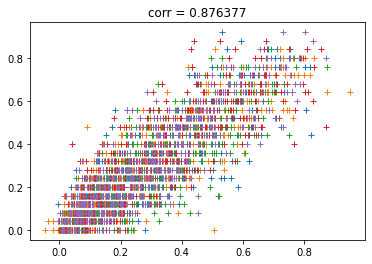

In [32]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn5 = Sequential()
    cnn5.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn5.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
    cnn5.add(MaxPooling3D(pool_size=2,padding='same'))
    cnn5.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn5.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn5.add(MaxPooling3D(pool_size=2,padding='same'))
    

    cnn5.add(Flatten())

    cnn5.add(Dense(512, activation='relu'))
    cnn5.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn5.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn5.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn5.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn5.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn5.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn5 Vgg MaxPooling")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    


Epoch 1/20
61/61 [==============================] - 5s 70ms/step - loss: 0.2075 - mse: 0.0704 - val_loss: 0.1491 - val_mse: 0.0345
Epoch 2/20
61/61 [==============================] - 4s 66ms/step - loss: 0.1318 - mse: 0.0286 - val_loss: 0.1116 - val_mse: 0.0208
Epoch 3/20
61/61 [==============================] - 4s 66ms/step - loss: 0.1089 - mse: 0.0192 - val_loss: 0.1004 - val_mse: 0.0166
Epoch 4/20
61/61 [==============================] - 4s 68ms/step - loss: 0.0932 - mse: 0.0142 - val_loss: 0.1006 - val_mse: 0.0171
Epoch 5/20
61/61 [==============================] - 4s 66ms/step - loss: 0.0909 - mse: 0.0136 - val_loss: 0.0944 - val_mse: 0.0149
Epoch 6/20
61/61 [==============================] - 4s 66ms/step - loss: 0.0841 - mse: 0.0119 - val_loss: 0.0948 - val_mse: 0.0146
Epoch 7/20
61/61 [==============================] - 4s 66ms/step - loss: 0.0760 - mse: 0.0100 - val_loss: 0.0995 - val_mse: 0.0173
Epoch 8/20
61/61 [==============================] - 4s 65ms/step - loss: 0.0760 - m

61/61 [==============================] - 4s 64ms/step - loss: 0.1173 - mse: 0.0228 - val_loss: 0.1114 - val_mse: 0.0206
Epoch 4/20
61/61 [==============================] - 4s 65ms/step - loss: 0.1000 - mse: 0.0172 - val_loss: 0.1060 - val_mse: 0.0189
Epoch 5/20
61/61 [==============================] - 4s 65ms/step - loss: 0.0911 - mse: 0.0142 - val_loss: 0.1014 - val_mse: 0.0161
Epoch 6/20
61/61 [==============================] - 4s 67ms/step - loss: 0.0897 - mse: 0.0140 - val_loss: 0.0927 - val_mse: 0.0141
Epoch 7/20
61/61 [==============================] - 4s 67ms/step - loss: 0.0820 - mse: 0.0116 - val_loss: 0.0969 - val_mse: 0.0159
Epoch 8/20
61/61 [==============================] - 4s 66ms/step - loss: 0.0788 - mse: 0.0109 - val_loss: 0.0912 - val_mse: 0.0140
Epoch 9/20
61/61 [==============================] - 7s 110ms/step - loss: 0.0734 - mse: 0.0097 - val_loss: 0.0888 - val_mse: 0.0132
Epoch 10/20
61/61 [==============================] - 4s 66ms/step - loss: 0.0727 - mse: 0.009

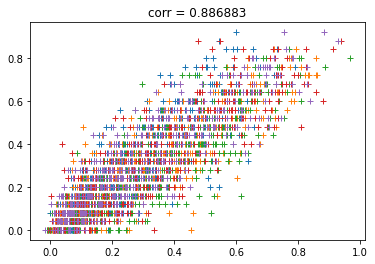

In [33]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    

    cnn6.add(Flatten())

    cnn6.add(Dense(512, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 Vgg AveragePooling")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 

In [ ]:
# Kernel 32,64,128 and dropout 0.2 lr=0.001

Epoch 1/20
61/61 [==============================] - 5s 47ms/step - loss: 0.1944 - mse: 0.0576 - val_loss: 0.1598 - val_mse: 0.0413
Epoch 2/20
61/61 [==============================] - 3s 44ms/step - loss: 0.1568 - mse: 0.0394 - val_loss: 0.1350 - val_mse: 0.0293
Epoch 3/20
61/61 [==============================] - 3s 45ms/step - loss: 0.1300 - mse: 0.0270 - val_loss: 0.1342 - val_mse: 0.0326
Epoch 4/20
61/61 [==============================] - 3s 44ms/step - loss: 0.1167 - mse: 0.0231 - val_loss: 0.1101 - val_mse: 0.0201
Epoch 5/20
61/61 [==============================] - 3s 43ms/step - loss: 0.1040 - mse: 0.0183 - val_loss: 0.1050 - val_mse: 0.0176
Epoch 6/20
61/61 [==============================] - 3s 43ms/step - loss: 0.0982 - mse: 0.0166 - val_loss: 0.1032 - val_mse: 0.0160
Epoch 7/20
61/61 [==============================] - 3s 44ms/step - loss: 0.0990 - mse: 0.0168 - val_loss: 0.0982 - val_mse: 0.0155
Epoch 8/20
61/61 [==============================] - 3s 44ms/step - loss: 0.0941 - m

61/61 [==============================] - 3s 43ms/step - loss: 0.1559 - mse: 0.0408 - val_loss: 0.1634 - val_mse: 0.0444
Epoch 4/20
61/61 [==============================] - 3s 43ms/step - loss: 0.1360 - mse: 0.0302 - val_loss: 0.1322 - val_mse: 0.0269
Epoch 5/20
61/61 [==============================] - 3s 44ms/step - loss: 0.1174 - mse: 0.0227 - val_loss: 0.1096 - val_mse: 0.0198
Epoch 6/20
61/61 [==============================] - 3s 44ms/step - loss: 0.1097 - mse: 0.0201 - val_loss: 0.1048 - val_mse: 0.0174
Epoch 7/20
61/61 [==============================] - 3s 42ms/step - loss: 0.0985 - mse: 0.0166 - val_loss: 0.1000 - val_mse: 0.0170
Epoch 8/20
61/61 [==============================] - 3s 44ms/step - loss: 0.0994 - mse: 0.0169 - val_loss: 0.0976 - val_mse: 0.0152
Epoch 9/20
61/61 [==============================] - 3s 45ms/step - loss: 0.0934 - mse: 0.0144 - val_loss: 0.1009 - val_mse: 0.0170
Epoch 10/20
61/61 [==============================] - 3s 46ms/step - loss: 0.0911 - mse: 0.0144

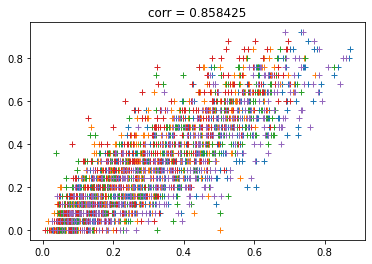

In [34]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))
    cnn6.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))

    cnn6.add(Flatten())

    cnn6.add(Dense(512, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 cnv_pool_conv_pool_conv_pool AveragePooling Kernel 32,64,128 and dropout 0.2 lr=0.001")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 

In [ ]:
# Kernel 32,64 and dropout 0.2 lr=0.001

Epoch 1/20
61/61 [==============================] - 4s 31ms/step - loss: 0.1841 - mse: 0.0538 - val_loss: 0.1662 - val_mse: 0.0446
Epoch 2/20
61/61 [==============================] - 1s 24ms/step - loss: 0.1644 - mse: 0.0421 - val_loss: 0.1351 - val_mse: 0.0284
Epoch 3/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1232 - mse: 0.0244 - val_loss: 0.1152 - val_mse: 0.0226
Epoch 4/20
61/61 [==============================] - 1s 24ms/step - loss: 0.1139 - mse: 0.0220 - val_loss: 0.1080 - val_mse: 0.0184
Epoch 5/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1073 - mse: 0.0185 - val_loss: 0.1136 - val_mse: 0.0225
Epoch 6/20
61/61 [==============================] - 1s 23ms/step - loss: 0.0997 - mse: 0.0165 - val_loss: 0.0986 - val_mse: 0.0156
Epoch 7/20
61/61 [==============================] - 1s 24ms/step - loss: 0.0907 - mse: 0.0140 - val_loss: 0.1043 - val_mse: 0.0177
Epoch 8/20
61/61 [==============================] - 1s 24ms/step - loss: 0.0936 - m

61/61 [==============================] - 1s 23ms/step - loss: 0.1435 - mse: 0.0336 - val_loss: 0.1448 - val_mse: 0.0353
Epoch 4/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1255 - mse: 0.0271 - val_loss: 0.1339 - val_mse: 0.0300
Epoch 5/20
61/61 [==============================] - 1s 24ms/step - loss: 0.1155 - mse: 0.0230 - val_loss: 0.1144 - val_mse: 0.0212
Epoch 6/20
61/61 [==============================] - 1s 24ms/step - loss: 0.1066 - mse: 0.0195 - val_loss: 0.1065 - val_mse: 0.0190
Epoch 7/20
61/61 [==============================] - 1s 24ms/step - loss: 0.0941 - mse: 0.0152 - val_loss: 0.0989 - val_mse: 0.0167
Epoch 8/20
61/61 [==============================] - 1s 23ms/step - loss: 0.0991 - mse: 0.0164 - val_loss: 0.0982 - val_mse: 0.0166
Epoch 9/20
61/61 [==============================] - 1s 23ms/step - loss: 0.0935 - mse: 0.0149 - val_loss: 0.1019 - val_mse: 0.0181
Epoch 10/20
61/61 [==============================] - 1s 24ms/step - loss: 0.0879 - mse: 0.0131

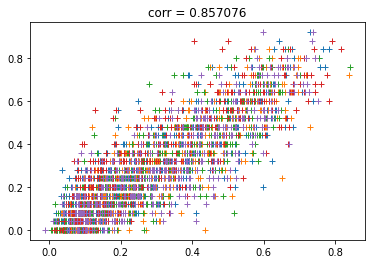

In [35]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))

    cnn6.add(Flatten())

    cnn6.add(Dense(512, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 cnv_pool_conv_pool_conv_pool AveragePooling Kernel 16,32,64 and dropout 0.2 lr=0.001")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 

Epoch 1/20
61/61 [==============================] - 4s 29ms/step - loss: 0.1978 - mse: 0.0616 - val_loss: 0.1627 - val_mse: 0.0414
Epoch 2/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1685 - mse: 0.0428 - val_loss: 0.1470 - val_mse: 0.0325
Epoch 3/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1344 - mse: 0.0290 - val_loss: 0.1238 - val_mse: 0.0253
Epoch 4/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1138 - mse: 0.0221 - val_loss: 0.1080 - val_mse: 0.0195
Epoch 5/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1062 - mse: 0.0192 - val_loss: 0.1065 - val_mse: 0.0182
Epoch 6/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1026 - mse: 0.0175 - val_loss: 0.1010 - val_mse: 0.0173
Epoch 7/20
61/61 [==============================] - 1s 23ms/step - loss: 0.0975 - mse: 0.0158 - val_loss: 0.0983 - val_mse: 0.0155
Epoch 8/20
61/61 [==============================] - 1s 23ms/step - loss: 0.0960 - m

61/61 [==============================] - 1s 22ms/step - loss: 0.1491 - mse: 0.0367 - val_loss: 0.1300 - val_mse: 0.0269
Epoch 4/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1202 - mse: 0.0238 - val_loss: 0.1208 - val_mse: 0.0253
Epoch 5/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1093 - mse: 0.0204 - val_loss: 0.1256 - val_mse: 0.0275
Epoch 6/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1105 - mse: 0.0211 - val_loss: 0.1034 - val_mse: 0.0170
Epoch 7/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1055 - mse: 0.0186 - val_loss: 0.1030 - val_mse: 0.0181
Epoch 8/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1004 - mse: 0.0174 - val_loss: 0.0982 - val_mse: 0.0158
Epoch 9/20
61/61 [==============================] - 1s 23ms/step - loss: 0.0970 - mse: 0.0156 - val_loss: 0.1090 - val_mse: 0.0192
Epoch 10/20
61/61 [==============================] - 1s 22ms/step - loss: 0.0916 - mse: 0.0146

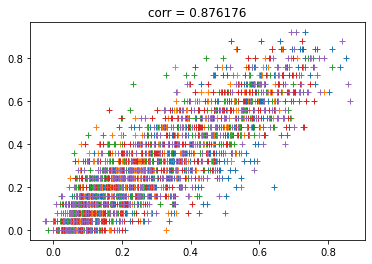

In [36]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))

    cnn6.add(Flatten())

    cnn6.add(Dense(512, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.01)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 cnv_pool_conv_pool_conv_pool AveragePooling Kernel 16,32,64 and dropout 0.2 lr=0.01")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 

Epoch 1/20
61/61 [==============================] - 4s 28ms/step - loss: 0.2066 - mse: 0.0707 - val_loss: 0.1749 - val_mse: 0.0537
Epoch 2/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1782 - mse: 0.0492 - val_loss: 0.1628 - val_mse: 0.0440
Epoch 3/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1543 - mse: 0.0375 - val_loss: 0.1318 - val_mse: 0.0279
Epoch 4/20
61/61 [==============================] - 1s 24ms/step - loss: 0.1243 - mse: 0.0253 - val_loss: 0.1236 - val_mse: 0.0266
Epoch 5/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1182 - mse: 0.0237 - val_loss: 0.1140 - val_mse: 0.0218
Epoch 6/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1087 - mse: 0.0201 - val_loss: 0.1060 - val_mse: 0.0190
Epoch 7/20
61/61 [==============================] - 1s 24ms/step - loss: 0.1043 - mse: 0.0184 - val_loss: 0.1066 - val_mse: 0.0181
Epoch 8/20
61/61 [==============================] - 1s 23ms/step - loss: 0.0975 - m

61/61 [==============================] - 1s 23ms/step - loss: 0.1438 - mse: 0.0333 - val_loss: 0.1502 - val_mse: 0.0386
Epoch 4/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1256 - mse: 0.0259 - val_loss: 0.1300 - val_mse: 0.0293
Epoch 5/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1106 - mse: 0.0210 - val_loss: 0.1066 - val_mse: 0.0191
Epoch 6/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1062 - mse: 0.0190 - val_loss: 0.1020 - val_mse: 0.0171
Epoch 7/20
61/61 [==============================] - 1s 23ms/step - loss: 0.0947 - mse: 0.0154 - val_loss: 0.1049 - val_mse: 0.0186
Epoch 8/20
61/61 [==============================] - 1s 23ms/step - loss: 0.0974 - mse: 0.0157 - val_loss: 0.1016 - val_mse: 0.0168
Epoch 9/20
61/61 [==============================] - 1s 24ms/step - loss: 0.0916 - mse: 0.0142 - val_loss: 0.0931 - val_mse: 0.0146
Epoch 10/20
61/61 [==============================] - 1s 22ms/step - loss: 0.0942 - mse: 0.0155

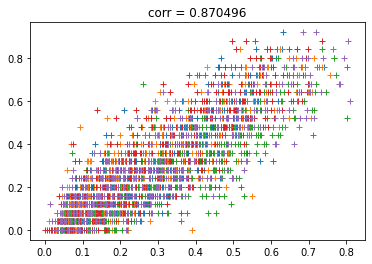

In [37]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))

    cnn6.add(Flatten())

    cnn6.add(Dense(512, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.1)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 cnv_pool_conv_pool_conv_pool AveragePooling Kernel 16,32,64 and dropout 0.2 lr=0.1")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 

Epoch 1/20
61/61 [==============================] - 4s 30ms/step - loss: 0.2080 - mse: 0.0705 - val_loss: 0.1675 - val_mse: 0.0453
Epoch 2/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1734 - mse: 0.0461 - val_loss: 0.1641 - val_mse: 0.0403
Epoch 3/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1624 - mse: 0.0413 - val_loss: 0.1577 - val_mse: 0.0427
Epoch 4/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1464 - mse: 0.0340 - val_loss: 0.1351 - val_mse: 0.0282
Epoch 5/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1238 - mse: 0.0252 - val_loss: 0.1232 - val_mse: 0.0251
Epoch 6/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1144 - mse: 0.0222 - val_loss: 0.1171 - val_mse: 0.0211
Epoch 7/20
61/61 [==============================] - 1s 21ms/step - loss: 0.1067 - mse: 0.0192 - val_loss: 0.1135 - val_mse: 0.0212
Epoch 8/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1047 - m

61/61 [==============================] - 1s 22ms/step - loss: 0.1481 - mse: 0.0359 - val_loss: 0.1393 - val_mse: 0.0321
Epoch 4/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1256 - mse: 0.0260 - val_loss: 0.1236 - val_mse: 0.0230
Epoch 5/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1161 - mse: 0.0232 - val_loss: 0.1131 - val_mse: 0.0224
Epoch 6/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1090 - mse: 0.0203 - val_loss: 0.1089 - val_mse: 0.0189
Epoch 7/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1091 - mse: 0.0205 - val_loss: 0.1059 - val_mse: 0.0186
Epoch 8/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1027 - mse: 0.0175 - val_loss: 0.1074 - val_mse: 0.0193
Epoch 9/20
61/61 [==============================] - 1s 22ms/step - loss: 0.0975 - mse: 0.0156 - val_loss: 0.1000 - val_mse: 0.0168
Epoch 10/20
61/61 [==============================] - 1s 22ms/step - loss: 0.0965 - mse: 0.0159

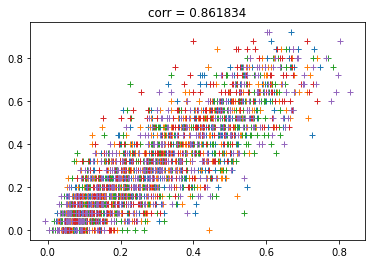

In [38]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))

    cnn6.add(Flatten())

    cnn6.add(Dense(256, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.01)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 cnv_pool_conv_pool_conv_pool AveragePooling Kernel 16,32,64 and dropout 0.2 lr=0.01 256")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 

Epoch 1/20
61/61 [==============================] - 4s 28ms/step - loss: 0.1899 - mse: 0.0556 - val_loss: 0.1773 - val_mse: 0.0448
Epoch 2/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1753 - mse: 0.0475 - val_loss: 0.1668 - val_mse: 0.0484
Epoch 3/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1572 - mse: 0.0391 - val_loss: 0.1415 - val_mse: 0.0325
Epoch 4/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1318 - mse: 0.0283 - val_loss: 0.1221 - val_mse: 0.0227
Epoch 5/20
61/61 [==============================] - 1s 24ms/step - loss: 0.1115 - mse: 0.0212 - val_loss: 0.1123 - val_mse: 0.0211
Epoch 6/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1102 - mse: 0.0207 - val_loss: 0.1034 - val_mse: 0.0177
Epoch 7/20
61/61 [==============================] - 1s 23ms/step - loss: 0.0998 - mse: 0.0166 - val_loss: 0.1046 - val_mse: 0.0169
Epoch 8/20
61/61 [==============================] - 1s 24ms/step - loss: 0.0967 - m

61/61 [==============================] - 1s 24ms/step - loss: 0.1677 - mse: 0.0436 - val_loss: 0.1722 - val_mse: 0.0420
Epoch 4/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1534 - mse: 0.0383 - val_loss: 0.1302 - val_mse: 0.0263
Epoch 5/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1274 - mse: 0.0261 - val_loss: 0.1188 - val_mse: 0.0227
Epoch 6/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1150 - mse: 0.0227 - val_loss: 0.1092 - val_mse: 0.0201
Epoch 7/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1041 - mse: 0.0184 - val_loss: 0.1040 - val_mse: 0.0181
Epoch 8/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1058 - mse: 0.0192 - val_loss: 0.1077 - val_mse: 0.0197
Epoch 9/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1019 - mse: 0.0174 - val_loss: 0.0998 - val_mse: 0.0161
Epoch 10/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1020 - mse: 0.0170

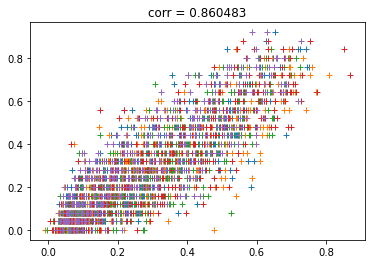

In [39]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))

    cnn6.add(Flatten())

    cnn6.add(Dense(1024, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.01)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 cnv_pool_conv_pool_conv_pool AveragePooling Kernel 16,32,64 and dropout 0.2 lr=0.01 1024")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 

Epoch 1/20
61/61 [==============================] - 4s 27ms/step - loss: 0.2041 - mse: 0.0695 - val_loss: 0.1656 - val_mse: 0.0471
Epoch 2/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1677 - mse: 0.0437 - val_loss: 0.1622 - val_mse: 0.0447
Epoch 3/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1535 - mse: 0.0377 - val_loss: 0.1380 - val_mse: 0.0304
Epoch 4/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1358 - mse: 0.0302 - val_loss: 0.1184 - val_mse: 0.0238
Epoch 5/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1159 - mse: 0.0219 - val_loss: 0.1176 - val_mse: 0.0245
Epoch 6/20
61/61 [==============================] - 3s 56ms/step - loss: 0.1154 - mse: 0.0219 - val_loss: 0.1132 - val_mse: 0.0209
Epoch 7/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1048 - mse: 0.0185 - val_loss: 0.1055 - val_mse: 0.0189
Epoch 8/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1041 - m

61/61 [==============================] - 1s 22ms/step - loss: 0.1416 - mse: 0.0333 - val_loss: 0.1303 - val_mse: 0.0256
Epoch 4/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1253 - mse: 0.0266 - val_loss: 0.1187 - val_mse: 0.0235
Epoch 5/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1156 - mse: 0.0221 - val_loss: 0.1099 - val_mse: 0.0195
Epoch 6/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1083 - mse: 0.0197 - val_loss: 0.1040 - val_mse: 0.0172
Epoch 7/20
61/61 [==============================] - 1s 22ms/step - loss: 0.1132 - mse: 0.0217 - val_loss: 0.1056 - val_mse: 0.0180
Epoch 8/20
61/61 [==============================] - 1s 23ms/step - loss: 0.1017 - mse: 0.0176 - val_loss: 0.1012 - val_mse: 0.0169
Epoch 9/20
61/61 [==============================] - 1s 22ms/step - loss: 0.0941 - mse: 0.0159 - val_loss: 0.1061 - val_mse: 0.0189
Epoch 10/20
61/61 [==============================] - 1s 22ms/step - loss: 0.0946 - mse: 0.0150

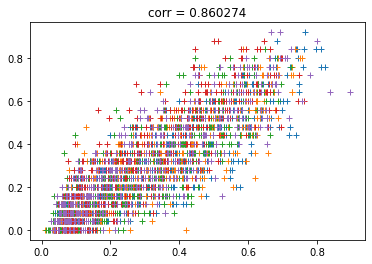

In [40]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.3))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.3))

    cnn6.add(Flatten())

    cnn6.add(Dense(512, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.01)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 cnv_pool_conv_pool_conv_pool AveragePooling Kernel 16,32,64 and dropout 0.3 lr=0.01 512")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 